# packages

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # important!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# Functions

In [7]:
#----------------------------------------
def AUC(y_true,y_probas):
    
#     print(y_probas)
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)


    classes = np.unique(y_true)
    probas = y_probas

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    average_score = (roc_auc[1]+roc_auc[2])/2
    return average_score


def precision(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    average_precision = {}
    for i in range(len(classes)):
        average_precision[i] = average_precision_score(y_true[:, i], probas[:, i])
        
    ave_precision = (average_precision[1]+average_precision[2])/2

    return ave_precision
    
def recall(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    recall_dict = {}
    for i in range(len(classes)):
        recall_dict[i] = recall_score(y_true[:, i], probas[:, i].round())
        
    ave_recall = (recall_dict[1]+recall_dict[2])/2

    return ave_recall


def accuracy(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    acc = {}
    for i in range(len(classes)):
        acc[i] = accuracy_score(y_true[:, i], probas[:, i].round())
        
    ave_acc = (acc[1]+acc[2])/2
    
    return ave_acc

#------------------------------------------------
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp

title_fontsize="small"
text_fontsize="small"
curves=('micro', 'macro', 'each_class')
cmap='nipy_spectral'


def plot_AUC(true_y,predict,title):


    plt.figure()
    y_true = true_y
    y_probas = predict
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    if 'micro' not in curves and 'macro' not in curves and \
            'each_class' not in curves:
        raise ValueError('Invalid argument for curves as it '
                         'only takes "micro", "macro", or "each_class"')

    classes = np.unique(y_true)
    probas = y_probas

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
       

    # Compute micro-average ROC curve and ROC area
    micro_key = 'micro'
    i = 0
    while micro_key in fpr:
        i += 1
        micro_key += str(i)

    y_true = label_binarize(y_true, classes=classes)
    if len(classes) == 2:
        y_true = np.hstack((1 - y_true, y_true))

    fpr[micro_key], tpr[micro_key], _ = roc_curve(y_true.ravel(),
                                                  probas.ravel())
    roc_auc[micro_key] = auc(fpr[micro_key], tpr[micro_key])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[x] for x in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    macro_key = 'macro'
    i = 0
    while macro_key in fpr:
        i += 1
        macro_key += str(i)
    fpr[macro_key] = all_fpr
    tpr[macro_key] = mean_tpr
    roc_auc[macro_key] = auc(fpr[macro_key], tpr[macro_key])
   

    title = title
    plt.title(title, fontsize=title_fontsize)

#         if 'each_class' in curves:
    for i in range(len(classes)):
        color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
        plt.plot(fpr[i], tpr[i], lw=2, color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

#         if 'micro' in curves:
    plt.plot(fpr[micro_key], tpr[micro_key],
            label='micro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[micro_key]),
            color='deeppink', linestyle=':', linewidth=4)

#         if 'macro' in curves:
    plt.plot(fpr[macro_key], tpr[macro_key],
            label='macro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[macro_key]),
            color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=text_fontsize)
    plt.ylabel('True Positive Rate', fontsize=text_fontsize)
    plt.tick_params(labelsize=text_fontsize)
    plt.legend(loc='lower right', fontsize=text_fontsize)
    plt.show()


# XGBoost

In [8]:
df_nlp = pd.read_pickle('./Target_Three/prediction_df_3.pkl')
df_market = pd.read_pickle('./Target_Three/prediction_df_market3.pkl')
df_all = pd.read_pickle('./Target_Three/prediction_df_all3.pkl')

In [9]:
df_nlp.head()

,index,idel_1,buy_1,sell_1,idel_2,buy_2,sell_2,idel_3,buy_3,sell_3,idel_4,buy_4,sell_4,idel_5,buy_5,sell_5,true_value
0,0,0.032134,0.957702,0.010164,0.149322,0.811396,0.039282,0.148675,0.795738,0.055587,1.0,0.000000e+00,0.0,0.497648,0.167892,0.334461,2.0
1,1,0.679917,0.010473,0.309610,0.832381,0.001645,0.165974,0.982293,0.004072,0.013634,1.0,0.000000e+00,0.0,0.252643,0.687501,0.059855,2.0
2,2,0.026585,0.708059,0.265356,0.386176,0.349389,0.264435,0.956251,0.028681,0.015067,1.0,0.000000e+00,0.0,0.061329,0.095472,0.843199,2.0
3,3,0.211322,0.438676,0.350002,0.501125,0.313757,0.185118,0.475901,0.315475,0.208624,1.0,0.000000e+00,0.0,0.379247,0.253717,0.367035,0.0
4,4,0.007234,0.975208,0.017559,0.006730,0.980034,0.013235,0.998783,0.001067,0.000150,1.0,3.161865e-21,0.0,0.012737,0.592409,0.394853,0.0


In [10]:
df_all.head()

,idel_1,buy_1,sell_1,idel_2,buy_2,sell_2,idel_3,buy_3,sell_3,idel_4,buy_4,sell_4,idel_5,buy_5,sell_5,true_value
0,0.006634,0.809143,0.184223,0.001441,0.537060,0.461499,0.053652,0.923298,0.023050,1.0,0.0,0.0,0.018977,0.690451,0.290572,2.0
1,0.000896,0.020155,0.978949,0.009996,0.578478,0.411527,0.117369,0.006983,0.875648,0.0,1.0,0.0,0.076212,0.626874,0.296914,2.0
2,0.000055,0.999313,0.000632,0.000323,0.971714,0.027963,0.005629,0.891749,0.102622,1.0,0.0,0.0,0.006421,0.848578,0.145002,2.0
3,0.000024,0.414127,0.585849,0.000380,0.386159,0.613460,0.001138,0.559314,0.439548,1.0,0.0,0.0,0.000090,0.021176,0.978734,2.0
4,0.232361,0.171181,0.596458,0.024217,0.454277,0.521506,0.000002,0.991298,0.008699,0.0,1.0,0.0,0.000018,0.100800,0.899182,2.0


## dataframe

In [11]:
result_dict = {}
auc_nlp = []
# acc_nlp = []
recall_nlp = []
pre_nlp = []
# auc_market = []
# acc_market = []
# recall_market = []
# pre_market = []
auc_all = []
# acc_all = []
recall_all = []
pre_all = []
y_true = df_nlp.as_matrix([['true_value']])

for i in range(5):
    predict_nlp = df_nlp.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    predict_market = df_market.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    predict_all = df_all.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    # ------ nlp ----------------
    auc_nlp.append(AUC(y_true,predict_nlp))
#     acc_nlp.append(accuracy(y_true,predict_nlp))
    recall_nlp.append(recall(y_true,predict_nlp))
    pre_nlp.append(precision(y_true,predict_nlp))
#     # ------ market -----------------
#     auc_market.append(AUC(y_true,predict_market))
#     acc_market.append(accuracy(y_true,predict_market))
#     recall_market.append(recall(y_true,predict_market))
#     pre_market.append(precision(y_true,predict_market))
     # ------ all-----------------
    auc_all.append(AUC(y_true,predict_all))
#     acc_all.append(accuracy(y_true,predict_all))
    recall_all.append(recall(y_true,predict_all))
    pre_all.append(precision(y_true,predict_all))
    
result_dict['AUC_nlp'] = auc_nlp
# result_dict['accuracy_nlp'] = acc_nlp
result_dict['recall_nlp'] = recall_nlp
result_dict['precision_nlp'] = pre_nlp
# result_dict['AUC_market'] = auc_market
# result_dict['accuracy_market'] = acc_market
# result_dict['recall_market'] = recall_market
# result_dict['precision_market'] = pre_market
result_dict['AUC_all'] = auc_all
# result_dict['accuracy_all'] = acc_all
result_dict['recall_all'] = recall_all
result_dict['precision_all'] = pre_all

In [12]:
pd.DataFrame.from_dict(result_dict)

,AUC_all,AUC_nlp,precision_all,precision_nlp,recall_all,recall_nlp
0,0.528293,0.475549,0.332008,0.291365,0.475694,0.318803
1,0.488395,0.481248,0.310997,0.302963,0.441403,0.179130
2,0.548350,0.492047,0.352802,0.300710,0.499748,0.240394
3,0.513827,0.475299,0.312185,0.295983,0.424018,0.149622
4,0.514624,0.519440,0.321690,0.325177,0.458260,0.262225


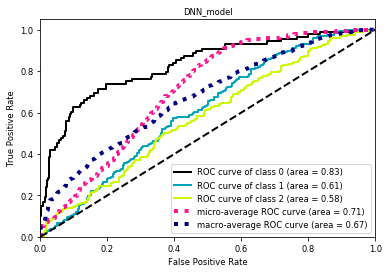

,AUC,accuracy,precision,recall
0,0.593334,0.555147,0.488196,0.28844


In [4]:
#============================================ neural network===================================
result_dict = {}
Auc = []
acc = []
Recall = []
Pre = []


pre = pd.read_pickle('./Target_Three/predictions.pickle').query('variable == "pred"')
pre = pre.loc[:,~pre.columns.duplicated()]
predicts = pre.as_matrix([['target_0_vb200_vf2_volatility_VWAP_200_0',
      'target_1_vb200_vf2_volatility_VWAP_200_0',
      'target_-1_vb200_vf2_volatility_VWAP_200_0']])
true = pd.read_pickle('./Target_Three/predictions.pickle').query('variable == "true"')
# drop duplicates
true = true.loc[:,~true.columns.duplicated()]
y_true = true.as_matrix([['target_0_vb200_vf2_volatility_VWAP_200_0',
  'target_1_vb200_vf2_volatility_VWAP_200_0',
  'target_-1_vb200_vf2_volatility_VWAP_200_0']])
y_true = np.argmax(y_true,axis=1)
plot_AUC(y_true,predicts,'DNN_model')

Auc.append(AUC(y_true,predicts))
acc.append(accuracy(y_true,predicts))
Recall.append(recall(y_true,predicts))
Pre.append(precision(y_true,predicts))

result_dict['AUC'] = Auc
result_dict['accuracy'] = acc
result_dict['recall'] = Recall
result_dict['precision'] = Pre
pd.DataFrame.from_dict(result_dict)



## Plot

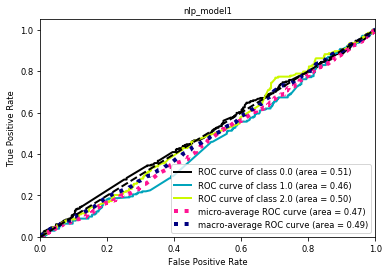

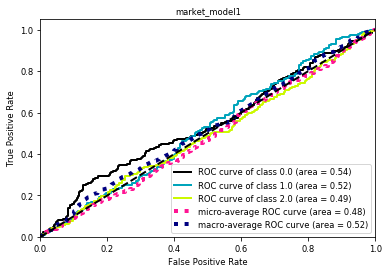

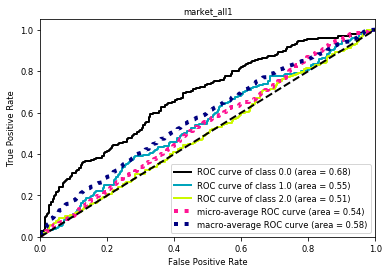

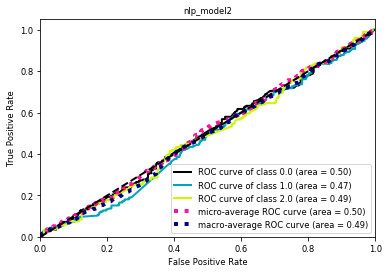

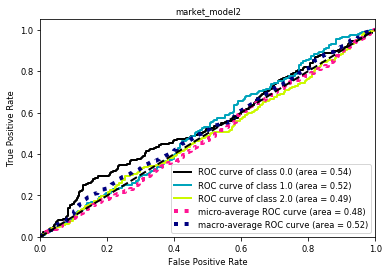

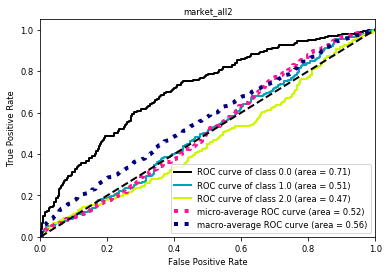

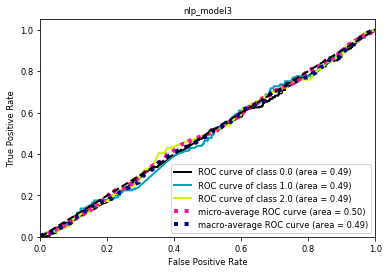

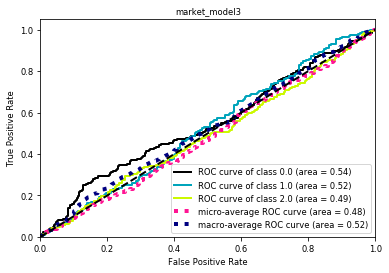

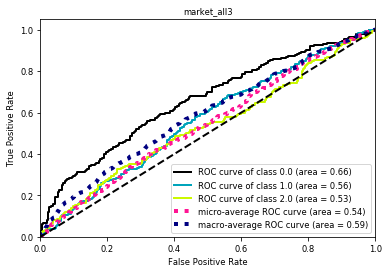

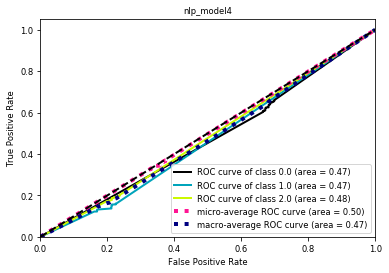

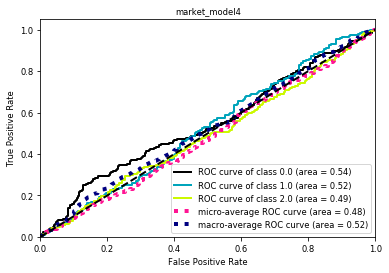

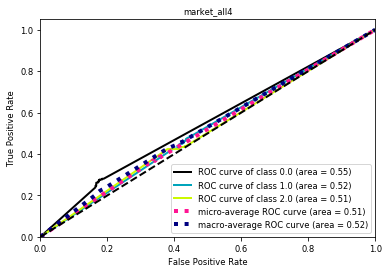

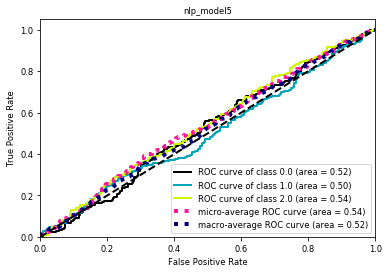

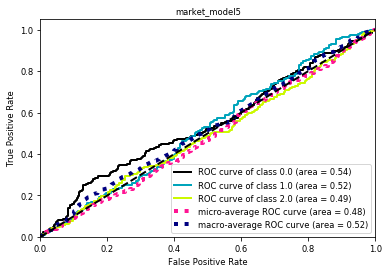

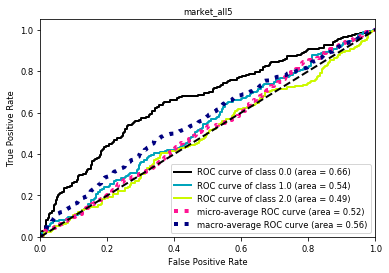

In [12]:
y_true = df_nlp.as_matrix([['true_value']])
for i in range(5):
    predict_nlp = df_nlp.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    predict_all = df_all.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    plot_AUC(y_true,predict_nlp,'nlp_model{}'.format(i+1))
    plot_AUC(y_true,predict_market,'market_model{}'.format(i+1))
    plot_AUC(y_true,predict_all,'market_all{}'.format(i+1))

# Neural network

## source + all_market_feats

In [9]:
import json
import pandas as pd
f = open('./Target_One/input.json','r')
r = json.loads(f.read())

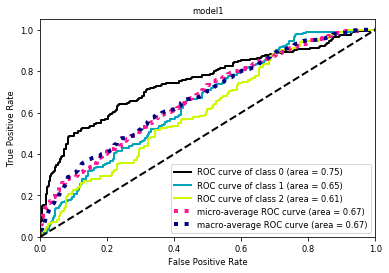

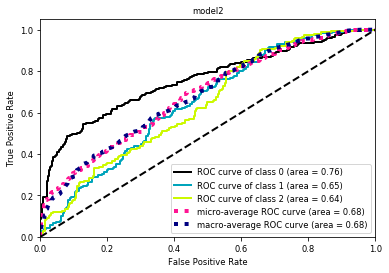

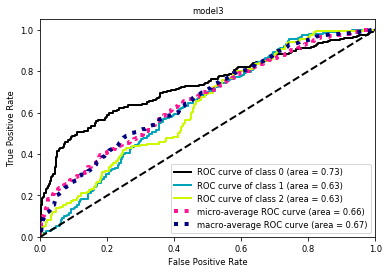

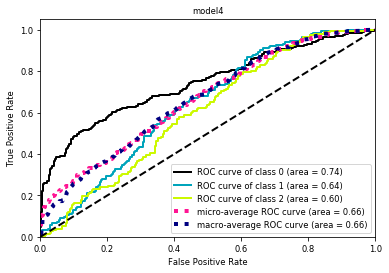

In [26]:
result_dict = {}
Auc = []
acc = []
Recall = []
Pre = []

for i in range(4):

    pre = pd.read_pickle('./Target_One/nn{}_predictions.pickle'.format(i+1)).query('variable == "pred"')
    pre = pre.loc[:,~pre.columns.duplicated()]
    predicts = pre.as_matrix([['target_0_vb100_vf2_volatility_VWAP_200_0',
          'target_1_vb100_vf2_volatility_VWAP_200_0',
          'target_-1_vb100_vf2_volatility_VWAP_200_0']])
    true = pd.read_pickle('./Target_One/nn{}_predictions.pickle'.format(i+1)).query('variable == "true"')
    # drop duplicates
    true = true.loc[:,~true.columns.duplicated()]
    y_true = true.as_matrix([['target_0_vb100_vf2_volatility_VWAP_200_0',
      'target_1_vb100_vf2_volatility_VWAP_200_0',
      'target_-1_vb100_vf2_volatility_VWAP_200_0']])
    y_true = np.argmax(y_true,axis=1)
    
    Auc.append(AUC(y_true,predicts))
    acc.append(accuracy(y_true,predicts))
    Recall.append(recall(y_true,predicts))
    Pre.append(precision(y_true,predicts))
    plot_AUC(y_true,predicts,'model{}'.format(i+1))
    
result_dict['AUC'] = Auc
result_dict['accuracy'] = acc
result_dict['recall'] = Recall
result_dict['precision'] = Pre

In [25]:
pd.DataFrame.from_dict(result_dict)

,AUC,accuracy,precision,recall
0,0.633668,0.687386,0.411711,0.133094
1,0.644908,0.685558,0.423260,0.097848
2,0.632289,0.674589,0.398768,0.134382
3,0.621463,0.689214,0.370741,0.033223
